In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read data
data= pd.read_excel('dummy_data.xlsx')

In [3]:
### convert values to mm 
data['Percolation(mm)'] = (data['Percolation (m^3)'] /data['Area (m^2)'])*1000
data['Runoff(mm)'] = data['Runoff (m^3)']/ data['Area (m^2)'] *1000
data['Latera;(mm)'] = data['Lateral (m^3)']/ data['Area (m^2)'] *1000

In [4]:
#############################################################################
            #Initialize P
#############################################################################
"""
Organic phosphorus levels are assigned assuming that the N:P ratio for 
humic materials is 8:1
humic_orgN1: Concentration of humic organic N in the layer (mg/kg) 
humic_orgP1: Concentration of humic organic P in the layer (mg/kg) 
orgC: amount of organic carbon in the layer (%)
"""
orgC = 30 ###################
humic_orgN1 = 10**4 * (orgC/14)

#############################################################################

"""
Users may define the concentration of  organic phosphorus (dry  weight  basis)
contained  in  humic  substances  for  all  soil  layers  at  the  beginning  
of  the  simulation.  If  the  user does  not  specify  initial  organic  P  
concentrations,  initialize  levels  of  organic  phosphorus  using  the 
following  equations (see Chapter  3:2 of SWAT the  Theoretical Documentation).
"""
humic_orgP1 = 0.125*humic_orgN1

#############################################################################

#fresh_orgP: P in the fresh organic pool in layer (kg P/ha)
"""P in fresh organic pool is set to 0 in all layers except top 10mm if soil."""
fresh_orgP = 2 ##################

#fresh_orgP: N in the fresh organic pool in layer (kg N/ha)
fresh_orgN = 20 ##################

#############################################################################
"""
Users may define the concentration of nitrate (dry weight basis) for all soil
layers at the beginning of the simulation. If  the  user  does  not specify 
initial  nitrate  concentrations, SWAT  will  initialize  levels of  nitrate
using  the  equations following  equations (see Chapter  3:2 of SWAT the 
Theoretical Documentation)
"""
lyr_dpth = 100
#NO3: amount of nitrate in layer (kg N/ha)
NO3 = 7 * np.exp(-lyr_dpth/1000) 


#############################################################################

#solP: Amount of phosphorus in solution (mg/kg)
"""
Users  may  define  the  concentration  of  solution  P  (dry weight  basis)  
for  all  soil  layers  at  the  beginning  of  the  simulation.  If  the  user 
does  not  specify  initial  solution  P concentrations,  SWAT  will  initialize
the  concentration  to  5 mg P/kg soil in all soil layers for unmanaged land under
native vegetation and 25 mg P kg−1 soil for cropland conditions (Neitsch et al. 2001).
"""
solP1 = 5

#############################################################################

"""
Bulk density values should fall between 1.1 and 1.9 Mg/m3.
"""
#layer bulk density (Mg/m3)
B_d = 1.3 

#############################################################################

#lyr_dpth: the depth of the layer (mm).
"""
The WEPP model makes use of up to ten soil layers, the top two with thicknesses
of 100 mm each and subsequent lower layers with thicknesses of 200 mm each 
(Wang, 2015: coupled WEPP-WQ module thesis)
"""
lyr_dpth = 100

In [5]:
"""convert all concentration values to mass values"""
# convert conc (mg/kg, etc) to mass (Kg P /ha)
solP = solP1 * B_d * lyr_dpth/100
humic_orgP = humic_orgP1* B_d * lyr_dpth/100
humic_orgN = humic_orgN1* B_d * lyr_dpth/100

In [6]:
"""
active_orgN1: concentration  of  nitrogen  in  the  active  organic  pool (mg/kg) #### Kg/ha used
stable_orgN1: concentration  of  nitrogen  in  the  stable  organic  pool (mg/kg) #### Kg/ha used
Fr: The fraction of humic nitrogen in the active pool
"""
Fr = 0.02 #default
active_orgN = humic_orgN * Fr
stable_orgN = humic_orgN * (1-Fr)

In [7]:
#############################################################################
            #MINERALIZATION & DECOMPOSITION/IMMOBILIZATION
#############################################################################

"""
Two  sources  are considered  for  mineralization:  the  fresh  organic  
P  pool  associated  with  crop residue and microbial biomass and the active
organic P pool associated with soil humus.  Mineralization  and  decomposition 
are  allowed  to  occur  only  if  the temperature of the soil layer
is above 0 degreeC. Mineralization and decomposition are dependent on water 
availability and temperature.  Two  factors  are  used  in  the  mineralization
and  decomposition equations to account for the impact of temperature and water
on these processes. 
NCTF: nutrient cycling temperature factor for each layer [not allowed to be smaller than 0.1]
NCWF: nutrient cycling water factor for each layer [not allowed to be smaller than 0.05]
soilT: temperature  of each layer in degreeC 
wc: soil water content for a given layer on a given day (mm)
fc: water content of a given layer at field capacity on a given day (mm)
"""

#NCTF = 0.9 * soilT/ soilT + np.exp(9.93-0.312*soilT) + 0.1
NCTF = 0.1 #########################
#NCWF = wc/fc
NCWF=0.05  #########################

In [8]:
"""
#############################################################################
                    #HUMUS MINERALIZATION
#############################################################################
active_orgP:  amount of phosphorus in the active organic pool (kg P/ha)
stable_orgP:  amount of phosphorus in the stable organic pool (kg P/ha)
minP_humicorgP: the phosphorus mineralized from the humus active organic P pool (kg  P/ha)
B_min: rate  coefficient  for  mineralization  of  the  humus  active organic nutrients
Phosphorus mineralized from the humus active organic pool is added to the
solution P pool in the layer
"""

active_orgP = humic_orgP * (active_orgN/active_orgN + stable_orgN)
stable_orgP = humic_orgP * (stable_orgN/active_orgN + stable_orgN)

B_min = 0.0003 ##############################

minP_humicorgP = 1.4* B_min * np.sqrt(NCTF*NCWF) * active_orgP

In [9]:
"""
#############################################################################
                #Decomposition and mineralization 
#############################################################################
Allowed only in first soil layer and controlled by a decay rate constant that 
is updated daily. 
The decay rate constant is  calculated  as  a  function  of  the  C:N  ratio 
and  C:P  ratio  of  the  residue, temperature and soil water content. 
E_cn: C:N ratio of the residue n the soil layer 
rsd: residue in layer ly (kg/ha)
0.58: fraction of residue that is carbon
fresh_orgN: nitrogen in the fresh organic pool in layer (kg N/ha)
NO3: amount of nitrate in layer (kg N/ha). 
E_cp: C:P ratio of the residue n the soil layer
solP : amount of phosphorus in solution in layer (kg P/ha)
fresh_orgP: hosphorus in the fresh organic pool in layer (kg P/ha).
"""

rsd=0.2 ############################### (same as RSD_COVCO Residue cover factor for 
                              ######### computing fraction of cover (0.1 –0.5)) ?????

E_cn = 0.58 * rsd /fresh_orgN + NO3

E_cp = 0.58 * rsd /fresh_orgP + solP


"""
DECAY RATE CONSTANT
The decay rate constant defines the fraction of residue that is decomposed. 
d_rate_const: decay rate constant 
B_rsd: The  fraction  of  residue  which  will  decompose  in  a  day assuming 
optimal  moisture,  temperature,  C:N  ratio  and  C:P ratio (default=0.05).
"""
a = np.exp(-0.693*(E_cn - 25)/25)
b = np.exp(-0.693*(E_cp - 200)/200)
c = [a,b,1]

"""
# NCRC: nutrient cycling residue composition factor
"""

NCRC = min(c)

B_rsd = 0.05

d_rate_const =  B_rsd * NCRC * np.sqrt(NCTF*NCWF)

#minP_freshorgP : Mineralization from the residue fresh organic P pool 
#decP_freshorgP : decomposition from the residue fresh organic P pool
minP_freshorgP = 0.8 * d_rate_const * fresh_orgP

decP_freshorgP = 0.2 * d_rate_const * fresh_orgP

In [10]:
#############################################################################
            #SORPTION OF INORGANIC P
#############################################################################

"""
SWAT assumes a rapid equilibrium exists between solution  P  and  an  “active”
mineral  pool. slow  reaction  is simulated  by  the  slow  equilibrium  
assumed  to  exist  between  the  “active”  and “stable”  mineral  pools. 
Equilibration between the solution and active mineral pool is governed by 
the phosphorus availability index (PAI)
solnP_f: amount  of phosphorus in solution after fertilization and incubation
solnP_i: amount  of phosphorus in solution before fertilization 
fert_minP: the amount of soluble P fertilizer added to the sample

PAI is calulated as:
PAI = solnP_f - solnP_i/fert_minP #Ag

if the value is not provided, default value is set to 0.4"""
PAI = 0.4

In [11]:
#############################################################################
        #MOVEMENT BETWEEN ACTIVE MINERAL POOL AND SOLUTION
#############################################################################
"""
The  movement  of  phosphorus  between  the  solution  and  active  mineral 
pools is governed by the equilibration equations: 
P_trans_sol_active_P: Amount of phosphorus transferred between the soluble and 
active mineral pool (kg P/ha). Positive value indicates transfer from 
solution to active mineral pool and vice a versa.
solP:  Amount of phosphorus in solution (kg P/ha)
active_minP: amount of phosphorus in the active mineral pool (kg P/ha)
"""
active_minP = solP * (1-PAI/PAI)
stable_minP = 4 * active_minP

if solP > active_minP * (PAI/(1-PAI)):
    P_trans_sol_active_P = 0.1*(solP - active_minP * (PAI/(1-PAI)))
    #print P_trans_sol_active_P
elif solP < active_minP * (PAI/(1-PAI)):
    P_trans_sol_active_P = 0.6*(solP - active_minP * (PAI/(1-PAI)))
    #print P_trans_sol_active_P

In [12]:
#############################################################################
#MOVEMENT BETWEEN STABLE MINERAL POOL AND SOLUTION 
#############################################################################
"""
When not in equilibrium, the movement of phosphorus between the active 
and stable mineral pools is governed by the equations:
B_eqp:: slow equilibrium constant set to 0.0006 per day
"""
B_eqp= 0.0006 
if stable_minP < 4 * active_minP:
    P_trans_sol_stable_P = B_eqp * (4 * active_minP - stable_minP)
elif stable_minP > 4 * active_minP:
    P_trans_sol_stable_P = 0.1 * B_eqp * (4 * active_minP - stable_minP)

In [13]:
#############################################################################
                            #P LEACHING
#############################################################################
"""
#P_perc : Amount of phosphorus moving from the top 10 mm into the first 
#soil layer (kg P/ha)
#solP_10mm : amount of phosphorus in solution in the top 10 mm (kg P/ha)
#W_prec_surf:  amount of water percolating to the first soil layer 
#from the top 10 mm on a given day (mm)
#B_d: bulk density of the top 10mm  (Mg/m3) (assumed  to  be  equivalent  to  
#bulk  density  of  first  soil  layer)
#dpth: depth of the “surface” layer (10 mm)
#Kd_perc: phosphorus percolation  coefficient  (m3/Mg)
"""

W_perc_surf = data['Percolation(mm)']
#solP_10mm = 1
#B_d = 1.3 #Bulk density values should fall between 1.1 and 1.9 Mg/m3. 
#dpth = 200
Kd_perc = 10 #The value can range from 10.0 to 17.5. default is 10

P_perc = (solP * W_perc_surf) / (10 * B_d * lyr_dpth * Kd_perc)

data['P_percolation(Kg P /ha)'] = P_perc

In [14]:
#############################################################################
                    #Fertilizer Application
    
#To predict the interaction of fertilizer  with  soil  and  runoff,  the  
#model  assumes  that  the  effective  depth  of  inter-action  of  runoff  
#with  soil  is  top  10  mm  and  runoff  transports  nutrients  that  are
#available only in the top 10 mm of soil. The amount of fertilizer not applied 
#in the top 10 mm of soil is added to the first soil layer
#############################################################################


In [15]:
#############################################################################
#When organic Fertilizer is applied, the model partitions it into fresh
#and humic pools using following equations

#fresh_orgP_fert: amount of P in the fresh organic pool added to the soil
#as a result of fertilizer application (kg P /ha)
#humic_orgP_fert: amount of P in the humus organic pool added to the soil 
#as a result of fertilizer application (kg P /ha)
#orgP_fert: fraction of organic Pin fertilizer
#fert: amount of fertilizer applied to the soil (kg /ha)

#############################################################################


# partitioning into fresh organic P 
#fresh_orgP_fert =  0.5* orgP_fert * fert
# partitioning into humic organic P
#humic_orgP_fert = 0.5* orgP_fert * fert



In [16]:
#############################################################################
            #Phosphorus Uptake by Plants
    
   # The  model assumes that plant uptake of P comes from the labile P pool 
#############################################################################
"""
P_uptake: plant P demand (kg /ha)[ Potential P uptake]
Bio_optp:  expected  amount  of  P  content  in  plant  biomass  at a  given  plant  stage
Bio_p: actual  amount  of  P  content  in  plant biomass
"""
Bio_optp = 2.5 ####################RANDOM
Bio_p = 1.7 #######################RANDOM

P_uptake = 1.5 *(Bio_optp - Bio_p) 

In [18]:
#############################################################################
        #P  uptake  from different soil lyr depths 
#############################################################################
"""
P_uptake: potential P uptake by the plant to soil depth (Kg/ha)
lyr_dpth: soil  depth  from  the  surface  (mm)
lyr_dpth_r: rooting depth (mm)
B_p: distribution parameter for P uptake default set to 20

"""
B_p = 20.0
lyr_dpth_r = 20

P_uptake = (P_uptake / 1-np.exp(-B_p))*(1-np.exp(-B_p*lyr_dpth/lyr_dpth_r))
P_uptake

1.1999999958776928

In [19]:
"""
The  P uptake  for  a  soil  layer  is  calculated  as  a  difference
between  P  uptake  at  the  lower and upper boundary of that soil layer.

P_actual: actual amount of P removed from soil #actUptake
P_uptake: 
P_demand: P  uptake  demand  not  met  by  overlying  soil  layers  (kg  P  /ha) # potUptake
P_sol: amount  of  labile  P  present  in  the  soil  (kg  P / ha). 

"""
P_demand = 1.1
P_actual = min((P_uptake + P_demand), solP)
P_actual

2.299999995877693

In [20]:
"""
P_stress: P stress for a given day.If a sufficient amount of P is not available in the soil for optimum plant growth,
plants may experience P stress.

P_stress varies non-linearly between 0, optimal P content and 1 when P content of the plant is <= 50% of optimal value 


phi_P: scaling factor
Bio_P: actual  P  content  of  plant  biomass (kg P /ha)
Bio_optp: optimum P content of plant biomass (kg P /ha)

"""
phi_P = 200 * (Bio_p /Bio_optp -0.5)
P_stress = 1 - phi_P /(phi_P + np.exp(3.535-0.02597*phi_P))



In [21]:
#############################################################################
            #PHOSPHORUS MOVEMENT IN SURFACE RUNOFF
#############################################################################
"""
P_surf: the  amount  of  soluble  P  transported  by  surface  runoff  (kg  P  ha−1)
solP: the amount of labile P (p in solution) in the top 10 mm (kg P /ha)
Q_surf: the amount of surface runoff on a given day as depth (mm)
B_d: bulk density of the top 10 mm of the soil (equivalent to B_d of first soil layer)
dpth: depth of surface soil layer (mm)
Kd_surf: phosphorus soil partitioning coefficient (m3/mg)
"""
Kd_surf = 175.0 ### default value
Q_surf= data['Runoff(mm)']

P_surf = solP * Q_surf/ B_d * lyr_dpth * Kd_surf

data['SolubleP(Kg P /ha)'] = P_surf

In [22]:
#############################################################################
#ORGANIC AND  MINERAL  PHOSPHORUS ATTACHED TO  SEDIMENT IN  SURFACE  RUNOFF
#############################################################################

#mass  of  P  transported  with  sediment  to  the  stream  
#uses a loading function developed by McElroy et al. (1976) and Williams and Hann (1978).

#SedP_surf:amount of P transported with sediment to the main channel in surface runoff (kg P/ ha)
#SedP_conc: concentration of P attached to sediment in top 10 mm (g P metric ton soil−1)
#sed: sediment yield on a given day (metric tons)
#area: HRU area (ha) (OFE in this case? or outlet for that matter, if we want values at the wshed outlet)
#E_ps: P enrichment ratio: The ratio of the concentration of P transported with the sediment to the 
      #concentration of P in the soil surface layer is  defined  as  the  P  enrichment  ratio 
#sed_conc_sq: concentration  of  sediment  in  surface  runoff  (mg  sediment /m3)
#############################################################################

sed = data['Sediment (tons)']
area= data['Area (m^2)'] * 1e-4

# Enrichment ratio is calculated for each storm event using formula by (Menzel 1980)
sed_conc_sq = sed / 10 * area * Q_surf
E_ps = 0.78 * (sed_conc_sq)**(- 0.2468)

sedP_conc = 100*(active_minP + stable_minP + humic_orgP + fresh_orgP/B_d * lyr_dpth)
SedP_surf = 0.001* sedP_conc *(sed/area) * E_ps

data['Sediment P (Kg P /ha)'] = SedP_surf

In [23]:
####### functions to display first and last n rows in dataframe###################
def front(self, n):
    return self.iloc[:, :n]

def back(self, n):
    return self.iloc[:, -n:]

pd.DataFrame.front = front
pd.DataFrame.back = back

In [24]:
data.front(50).back(50)

,Date,Area (m^2),Percolation (m^3),Runoff (m^3),Lateral (m^3),Sediment (tons),Percolation(mm),Runoff(mm),Latera;(mm),P_percolation(Kg P /ha),SolubleP(Kg P /ha),Sediment P (Kg P /ha)
0,1990-01-01,2.776800e+07,131474.192189,0.000000,22.387133,0.0000,4.734738,0.000000,0.000806,0.002367,0.000000,NaN
1,1990-01-02,2.776800e+07,173530.699749,0.000000,16.767037,0.0000,6.249305,0.000000,0.000604,0.003125,0.000000,NaN
2,1990-01-03,2.776800e+07,195995.013653,0.000000,2103.702096,0.0000,7.058305,0.000000,0.075760,0.003529,0.000000,NaN
3,1990-01-04,2.776800e+07,187897.674985,0.000000,5.653421,0.0000,6.766698,0.000000,0.000204,0.003383,0.000000,NaN
4,1990-01-05,2.776800e+07,163725.131157,0.000000,3.268000,0.9090,5.896180,0.000000,0.000118,0.002948,0.000000,inf
5,1990-01-06,2.776800e+07,138637.212472,490.643423,0.076000,0.8783,4.992697,0.017669,0.000003,0.002496,1546.070994,0.062552
6,1990-01-07,2.776800e+07,117554.357043,2339.390764,5227.843202,1.0347,4.233447,0.084248,0.188269,0.002117,7371.675714,0.048132
7,1990-01-08,2.776800e+07,99831.909987,27756.006230,44953.093966,28.0212,3.595214,0.999568,1.618881,0.001798,87462.206048,0.313617
8,1990-01-09,2.776800e+07,92774.521215,28657.534141,45862.245046,1.5894,3.341059,1.032035,1.651622,0.001671,90303.018924,0.035834
9,1990-01-10,2.776800e+07,116337.133238,7731.883072,34064.070468,20.9841,4.189612,0.278446,1.226738,0.002095,24364.007732,0.345773


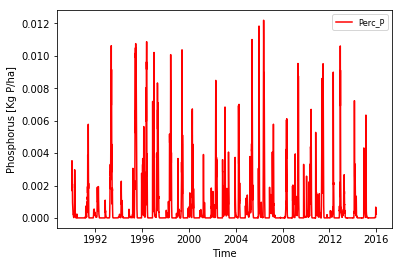

In [25]:
plt.plot( 'Date', 'P_percolation(Kg P /ha)', data=data, color='red', label = 'Perc_P')
plt.xlabel('Time')
plt.ylabel('Phosphorus [Kg P/ha]')
plt.legend(prop={'size': 8})

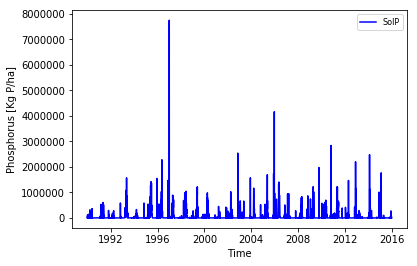

In [26]:
plt.plot( 'Date', 'SolubleP(Kg P /ha)', data=data, color='blue', label = 'SolP')
plt.xlabel('Time')
plt.ylabel('Phosphorus [Kg P/ha]')
plt.legend(prop={'size': 8})

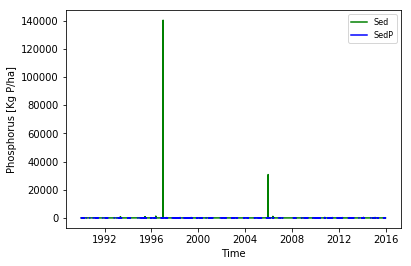

In [27]:
plt.plot( 'Date', 'Sediment (tons)', data=data, color='green', label = 'Sed')
plt.plot( 'Date', 'Sediment P (Kg P /ha)', data=data, color='blue', label = 'SedP')
plt.xlabel('Time')
plt.ylabel('Phosphorus [Kg P/ha]')
plt.legend(prop={'size': 8}) 

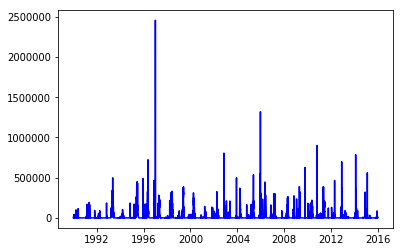

In [28]:
plt.plot( 'Date', 'Runoff (m^3)', data=data, color='blue', label = 'Q_surf')

In [ ]:
############ P Loading from Ground Water########
##subroutine gwnutr
#GW_q:     groundwater contribution to streamflow from HRU (OFE in WEPP's case?) on current day (mm)
#GW_minP:  soluble P concentration in groundwater loading to reach (mg/L)
#minP_GW:   soluble P loading to reach in groundwater (kg P/ha)      |
minP_GW = GW_minP * GW_q / 100

#bmp adjustment 
#bmp_sns: ????????? bmp_sp refers to Soluble P removal by BMP. something similar ?
#minP_GW = minP_GW * bmp_sns

In [ ]:
########## P loading from Later flow###########
##subroutine latsed
#organic n and p in the lateral flow     - by J.Jeong BREC 2011 revised 2014  
#1mm*mg/L*1000L/m3*kg/1000000mg*10m3/(ha-mm)=0.01kg/ha
#lat_q:  total lateral flow in soil profile for the day in HRU (mm)
#sed_orgP: amount of organic phosphorus in surface runoff in HRU for the day (kg P/ha)
 
#sedorgn(j) = sedorgn(j) +(latq(j) + gw_q(j)) * lat_orgn(j) / 100.
sed_orgP = sed_orgP +(lat_q + GW_q) * lat_orgP / 100. ##Update to total sed_orgP? doesn't seem to be just P from lat_q

####bmp adjustments
#sedorgn(j) = sedorgn(j) * bmp_pns(j)
#sed_orgP = sed_orgP * bmp_pps
